# BERT-model

### Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from time import time
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

from tools.bert_model import get_model, MAX_LEN
from tools.visuals import plot_history, show_bert_accuracy

import warnings
warnings.filterwarnings('ignore')

/Users/aliozcan/miniforge3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-01 18:21:35.299018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 18:21:35.299154: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some layers from the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you 

### Read data

In [2]:
folder_path = '../../data/cleaned_data/cleaned_text_data_with_stopwords_2022.csv'

data = pd.read_csv(folder_path)

data.head()

,full_text,real_fake_grade,text_metadata,combined
0,daily update published state reported 734k tes...,1.0,covid tracking project try provide comprehensi...,covid tracking project try provide comprehensi...
1,president trump asked would catch coronavirus ...,-1.0,spoof spoof news political satire parody gossi...,spoof spoof news political satire parody gossi...
2,state reported death still seeing solid nation...,1.0,covid tracking project try provide comprehensi...,covid tracking project try provide comprehensi...
3,low vitamind independent predictor worse progn...,1.0,medscape medscape provides breaking medical ne...,medscape medscape provides breaking medical ne...
4,common question cumulative outcome number smal...,1.0,covid tracking project try provide comprehensi...,covid tracking project try provide comprehensi...


In [3]:
data.shape

(7903, 4)

In [4]:
data.dropna(inplace=True)
data.shape

(7901, 4)

### Pre-processing

Verander de -1 (fake) naar een positief getal. Dit is nodig voor to_categorical

In [5]:
data['real_fake_grade']  = data['real_fake_grade'].map({0:0, 1:1, -1:2})

---

## Models

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2')

In [7]:
y = data['real_fake_grade']

def get_data(X, maxlen=MAX_LEN):

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

    y_train_encoded = to_categorical(y_train)
    y_val_encoded = to_categorical(y_val)

    # Tokenize the input (takes some time) 
    x_train = tokenizer(
        text=X_train.tolist(),
        add_special_tokens=True,
        max_length=maxlen,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True)
    x_val = tokenizer(
        text=X_val.tolist(),
        add_special_tokens=True,
        max_length=maxlen,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True)
    x_test = tokenizer( # for prediction
        text=X_test.tolist(),
        add_special_tokens=True,
        max_length=maxlen,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True)
    

    return x_train, y_train_encoded, x_val, y_val_encoded, x_test, y_test

In [10]:
X_train_tokenized, y_train_encoded, X_val_tokenized, y_val_encoded, X_test_tokenized, y_test = get_data(data['combined'])
combined_model = get_model()

In [11]:
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPooling(last_hidd               'attention_mask[0][0]']         
                                en_state=(None, 128                                               
                                , 1024),                                                      

In [12]:
start = time()
combined_history = combined_model.fit(
    x ={'input_ids':X_train_tokenized['input_ids'],'attention_mask':X_train_tokenized['attention_mask']} ,
    y = y_train_encoded,
    validation_data = (
    {'input_ids':X_val_tokenized['input_ids'],'attention_mask':X_val_tokenized['attention_mask']}, y_val_encoded
    ),
  epochs=4,
    batch_size=32
)
end = time()

combined_train_time = end - start
combined_train_time

Epoch 1/4


2022-05-31 21:14:23.295887: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-31 21:14:34.184275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - ETA: 0s - loss: 0.7608 - accuracy: 0.6675 

2022-05-31 21:58:28.577345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 2677s 16s/step - loss: 0.7608 - accuracy: 0.6675 - val_loss: 0.5993 - val_accuracy: 0.7420
Epoch 2/4
167/167 [==============================] - 2931s 18s/step - loss: 0.4830 - accuracy: 0.8021 - val_loss: 0.4809 - val_accuracy: 0.8027
Epoch 3/4
167/167 [==============================] - 2987s 18s/step - loss: 0.3736 - accuracy: 0.8573 - val_loss: 0.4648 - val_accuracy: 0.8027
Epoch 4/4
167/167 [==============================] - 3001s 18s/step - loss: 0.3024 - accuracy: 0.8862 - val_loss: 0.5065 - val_accuracy: 0.7926


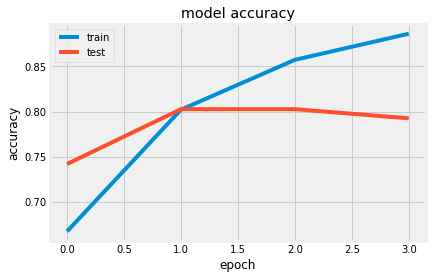

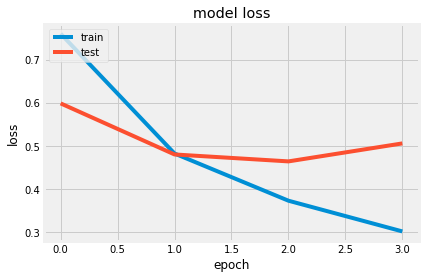

In [13]:
plot_history(combined_history)

In [19]:
start = time()
show_bert_accuracy(combined_model, X_test_tokenized, y_test)
end = time()

combined_test_time = end - start
print(f"test time: {combined_test_time}")

Accuracy score: 0.8355263157894737
test time: 78.09901213645935


### Tweet

In [8]:
X_train_tokenized, y_train_encoded, X_val_tokenized, y_val_encoded, X_test_tokenized, y_test = get_data(data['full_text'], maxlen=80)
tweet_2022_model = get_model(maxlen=80)

In [9]:
start = time()
tweet_history = tweet_2022_model.fit(
    x ={'input_ids':X_train_tokenized['input_ids'],'attention_mask':X_train_tokenized['attention_mask']} ,
    y = y_train_encoded,
    validation_data = (
    {'input_ids':X_val_tokenized['input_ids'],'attention_mask':X_val_tokenized['attention_mask']}, y_val_encoded
    ),
  epochs=4,
    batch_size=32
)
end = time()

tweet_train_time = end - start
print(f"train time: {tweet_train_time}")

Epoch 1/4


2022-06-01 18:22:11.313648: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-01 18:22:22.915952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - ETA: 0s - loss: 0.8130 - accuracy: 0.6262

2022-06-01 18:46:35.126608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 1493s 9s/step - loss: 0.8130 - accuracy: 0.6262 - val_loss: 0.6725 - val_accuracy: 0.7268
Epoch 2/4
167/167 [==============================] - 1260s 8s/step - loss: 0.5872 - accuracy: 0.7671 - val_loss: 0.5688 - val_accuracy: 0.7858
Epoch 3/4
167/167 [==============================] - 1234s 7s/step - loss: 0.4670 - accuracy: 0.8211 - val_loss: 0.5344 - val_accuracy: 0.7909
Epoch 4/4
167/167 [==============================] - 1242s 7s/step - loss: 0.3843 - accuracy: 0.8620 - val_loss: 0.5424 - val_accuracy: 0.8027
train time: 5229.529034852982


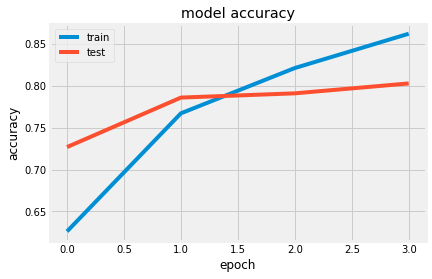

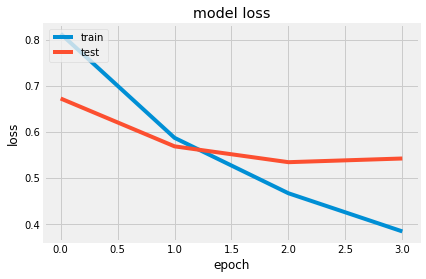

In [10]:
plot_history(tweet_history)

In [11]:
start = time()
show_bert_accuracy(tweet_2022_model, X_test_tokenized, y_test)
end = time()
tweet_test_time = end - start

2022-06-01 19:50:41.151754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy score: 0.8137651821862348


In [15]:
print(f"train time: {tweet_train_time}")
print(f"test time: {tweet_test_time}")

train time: 5229.529034852982
test time: 58.70046782493591


### Text Metadata

In [8]:
X_train_tokenized, y_train_encoded, X_val_tokenized, y_val_encoded, X_test_tokenized, y_test = get_data(data['text_metadata'])
text_metadata_model = get_model()

In [10]:
start = time()

text_metadata_history = text_metadata_model.fit(
    x ={'input_ids':X_train_tokenized['input_ids'],'attention_mask':X_train_tokenized['attention_mask']} ,
    y = y_train_encoded,
    validation_data = (
    {'input_ids':X_val_tokenized['input_ids'],'attention_mask':X_val_tokenized['attention_mask']}, y_val_encoded
    ),
  epochs=4,
    batch_size=32
)

end = start()

text_metadata_triain_time = end - start

Epoch 1/4


2022-05-31 12:15:10.887938: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-31 12:15:21.721670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - ETA: 0s - loss: 0.7677 - accuracy: 0.6487 

2022-05-31 13:02:52.276346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 2897s 17s/step - loss: 0.7677 - accuracy: 0.6487 - val_loss: 0.6309 - val_accuracy: 0.7099
Epoch 2/4
167/167 [==============================] - 2693s 16s/step - loss: 0.6276 - accuracy: 0.7099 - val_loss: 0.5886 - val_accuracy: 0.7403
Epoch 3/4
167/167 [==============================] - 2636s 16s/step - loss: 0.5752 - accuracy: 0.7446 - val_loss: 0.5825 - val_accuracy: 0.7369
Epoch 4/4
167/167 [==============================] - 2882s 17s/step - loss: 0.5402 - accuracy: 0.7598 - val_loss: 0.5827 - val_accuracy: 0.7437


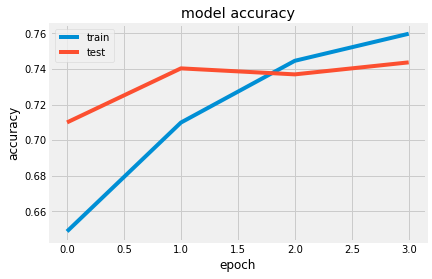

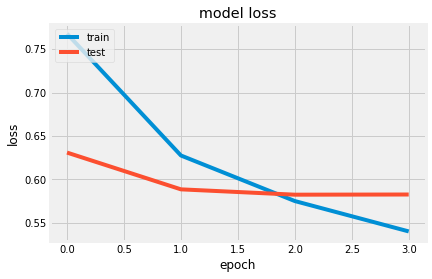

In [11]:
plot_history(text_metadata_history)

In [15]:
from time import time

start = time()
show_bert_accuracy(combined_model, X_test_tokenized, y_test)
end = time()
text_metadata_test_time = end - start
text_metadata_test_time

Accuracy score: 0.7246963562753036


79.05284404754639

### Save models

combined

In [16]:
combined_model.save_weights("./results/bert/bert-combined-weights.h5")

tweet

In [13]:
tweet_2022_model.save_weights("./results/bert/bert-tweet2022-weights.h5")

text metadata

In [41]:
text_metadata_model.save_weights("./results/bert/bert-text-metadata-weights.h5")

### Loading a model example

In [13]:
test = get_model()

test.load_weights("./results/bert/bert-text-metadata-weights.h5")


In [15]:
show_bert_accuracy(test, X_test_tokenized, y_test)

2022-05-31 16:13:30.981383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy score: 0.7246963562753036


### Resultaten


|      	| accuracy 	| training time (s)     	| test time (s)|
|------	|-------------	|-------	| ------|
| Tweet 2022 	| 0.814     	|  5229  | 58|
| Tweet 2021    	| -       |-	| - |
| Text metadata    	| 0.72       |11100 	| 79|
| Combined    	| 0.836        	| 11580| 78|

### Bronnen 

- https://arxiv.org/pdf/1810.04805.pdf (authors of BERT)